# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [2]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.09544539451599121ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

## Relabeling and normilizing

In [3]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='angry')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+02, tolerance: 6.656e-02

Text(0, 0.5, 'Coeffs')

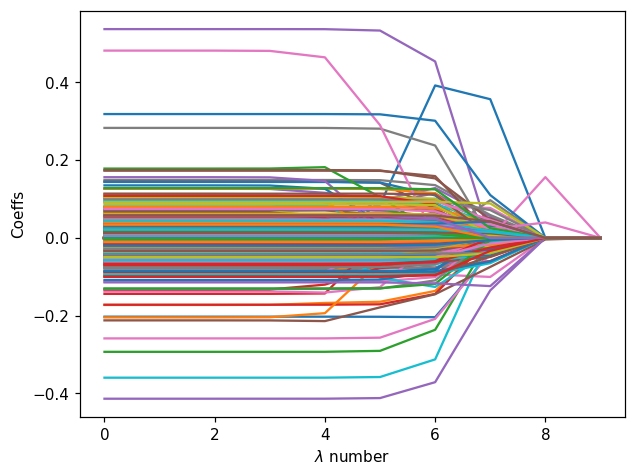

In [4]:

Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [5]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [6]:
np.save('data/Lasso_Ranking_angry_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_angry_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.7314
Iter =  2  AUC = 0.7406
Iter =  3  AUC = 0.7608
Iter =  5  AUC = 0.7628
Iter =  7  AUC = 0.7686
Iter =  8  AUC = 0.7885
Iter =  9  AUC = 0.7985
Iter =  10  AUC = 0.8089
Iter =  11  AUC = 0.8231
Iter =  36  AUC = 0.8261
Iter =  39  AUC = 0.8335
Iter =  47  AUC = 0.8456
Iter =  60  AUC = 0.8488
Iter =  71  AUC = 0.8494
Iter =  72  AUC = 0.8508
Iter =  77  AUC = 0.8510
Iter =  78  AUC = 0.8542
Iter =  79  AUC = 0.8572
Iter =  80  AUC = 0.8586
Iter =  82  AUC = 0.8640
auc_best = 0.86398237


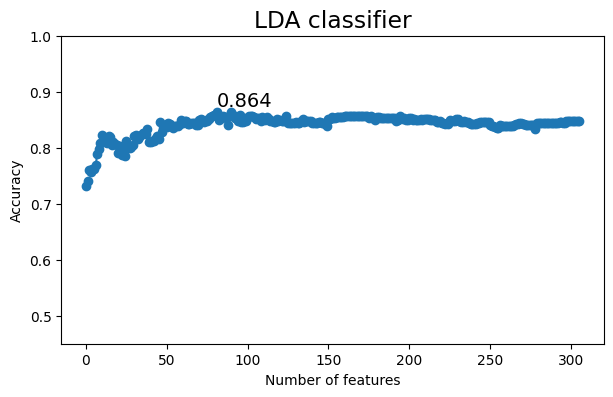

In [7]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [8]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.8639823717948718 Number of features =  81


# Backward step selection

In [9]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [10]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.855 <-> 0.864
Iter #1: 0.850 <-> 0.864
Iter #2: 0.843 <-> 0.864
Iter #3: 0.853 <-> 0.864
Iter #4: 0.859 <-> 0.864
Iter #5: 0.862 <-> 0.864
Iter #6: 0.859 <-> 0.864
Iter #7: 0.852 <-> 0.864
Iter #8: 0.854 <-> 0.864
Iter #9: 0.857 <-> 0.864
Iter #10: 0.861 <-> 0.864
Iter #11: 0.856 <-> 0.864
Iter #12: 0.857 <-> 0.864
Iter #13: 0.860 <-> 0.864
Iter #14: 0.852 <-> 0.864
Iter #15: 0.855 <-> 0.864
Iter #16: 0.862 <-> 0.864
Iter #17: 0.849 <-> 0.864
Iter #18: 0.864 <-> 0.864
Iter #19: 0.863 <-> 0.864
Iter #20: 0.861 <-> 0.864
Iter #21: 0.858 <-> 0.864
Iter #22: 0.856 <-> 0.864
Iter #23: 0.855 <-> 0.864
Iter #24: 0.851 <-> 0.864
Iter #25: 0.863 <-> 0.864
Iter #26: 0.857 <-> 0.864
Iter #27: 0.857 <-> 0.864
Iter #28: 0.861 <-> 0.864
Iter #29: 0.857 <-> 0.864
Iter #30: 0.858 <-> 0.864
Iter #31: 0.863 <-> 0.864
Iter #32: 0.863 <-> 0.864
Iter #33: 0.858 <-> 0.864
Iter #34: 0.855 <-> 0.864
Iter #35: 0.856 <-> 0.864
Iter #36: 0.856 <-> 0.864
Iter #37: 0.853 <-> 0.864
Iter #38: 0.

Iter #68: 0.865 <-> 0.865
Iter #69: 0.860 <-> 0.865
Iter #70: 0.858 <-> 0.865
Iter #71: 0.858 <-> 0.865
Iter #72: 0.857 <-> 0.865
Iter #73: 0.853 <-> 0.865
Iter #74: 0.857 <-> 0.865
Iter #75: 0.860 <-> 0.865
Iter #76: 0.860 <-> 0.865
Iter #77: 0.860 <-> 0.865
Iter #78: 0.843 <-> 0.865


In [11]:
np.save('data/feature_idx_angry.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_angry.npy')

# 5-fold CV (full feature space)

In [12]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.19it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.31it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.18it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.96it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.12it/s]

UAR = 0.456


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.17it/s]

UAR = 0.454


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.62it/s]

UAR = 0.444


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.39it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.59it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


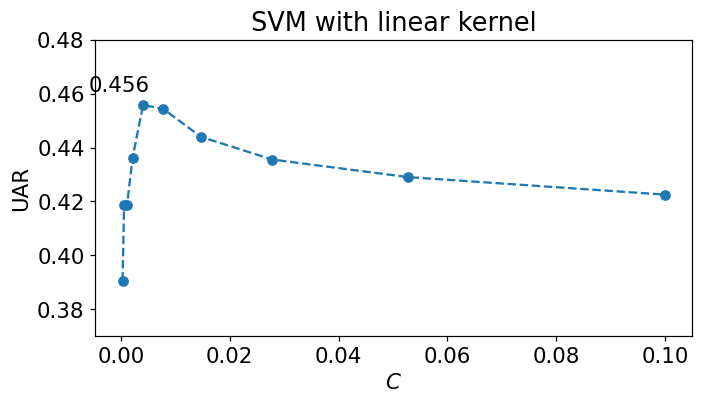

In [13]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

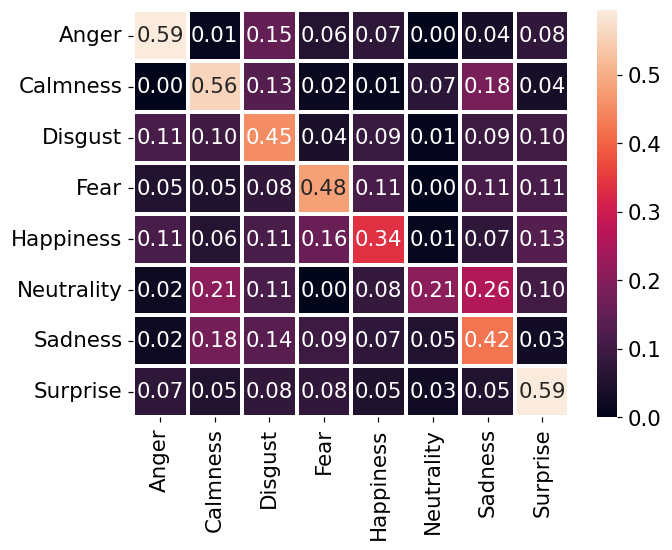

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [14]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [15]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [16]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,0.327919,-1.276835,-0.865550,0.350214,0.232478,-0.746101,-1.095382,-0.510118,0.091157,0.114938,...,0.159116,-0.798941,1.498376,-0.134332,-0.838209,0.378692,-0.542375,0.027009,-0.547827,-1.106907
1,-0.483370,-1.043824,-0.558509,0.204453,0.019477,-0.591594,-1.408964,-1.521874,-0.513553,-0.977861,...,0.936533,-0.173629,-0.672245,-0.355068,-0.404907,-0.966724,-0.898757,-1.266864,-0.879547,0.513084
2,-0.982420,-0.935299,-0.112181,0.239656,0.957926,-0.966012,-0.512453,-0.572497,-0.435643,-0.209102,...,0.230524,0.177662,0.017010,0.376201,-0.139555,-0.800947,-0.504110,-0.658042,1.028115,-0.740132
3,0.968978,-1.784177,-0.871340,0.599826,-1.274009,-1.805384,-2.128017,-1.842742,-0.365858,1.859423,...,-0.449243,0.273819,-0.452109,-0.354393,0.440215,1.074379,0.726495,1.484668,-0.850787,-0.529074
4,0.548798,-1.564315,-0.530920,0.417719,-0.189412,-1.566068,-2.994249,-0.689512,1.209200,0.818964,...,-0.240188,-0.468580,-1.183403,0.125480,1.696746,1.049962,0.763248,1.113329,-0.862193,-0.077498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.137958,-0.318359,-0.962037,0.098770,-1.766759,0.143682,-1.194660,-0.467109,-0.328484,-0.292767,...,-0.404667,-1.409358,-1.458692,-0.391358,-0.225792,1.622761,1.591309,0.950851,0.196229,-0.998586
1436,1.705626,-0.526947,-0.051689,1.207089,-0.502260,0.604930,-1.516659,0.733979,0.302839,0.891982,...,-0.126977,-0.688855,-0.337889,-0.425734,1.363530,1.612017,1.796934,0.208898,1.749666,0.400631
1437,0.619210,-0.515158,-0.309895,-1.095740,-1.154320,-0.711070,-0.082427,1.062587,0.545192,0.671729,...,-1.003486,-1.481660,-1.469254,0.415159,0.518025,1.289363,-0.775856,-1.135514,0.680585,-0.819892
1438,-0.363270,0.238985,-0.512036,-0.717332,-0.791417,-0.131286,-0.405870,-0.820105,-1.451104,-1.192889,...,-0.510099,-1.515311,-1.138011,-0.730082,-0.844747,1.473954,0.937051,1.047499,0.686091,-0.815675


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.80it/s]

UAR = 0.331


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.21it/s]

UAR = 0.337


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.71it/s]

UAR = 0.350


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.53it/s]

UAR = 0.366


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.76it/s]

UAR = 0.369


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.85it/s]

UAR = 0.386


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.87it/s]

UAR = 0.397


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.38it/s]

UAR = 0.401


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.55it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.03it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.05it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.41it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.67it/s]

UAR = 0.418


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.65it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.31it/s]

UAR = 0.415


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.59it/s]

UAR = 0.416


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.51it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.40it/s]

UAR = 0.416


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.22it/s]

UAR = 0.420


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.31it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.14it/s]

UAR = 0.420


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.25it/s]

UAR = 0.424


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.69it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.39it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.52it/s]

UAR = 0.418


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.18it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.47it/s]

UAR = 0.425


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.12it/s]

UAR = 0.425


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.32it/s]

UAR = 0.424


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.17it/s]

UAR = 0.428


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.70it/s]

UAR = 0.425


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.64it/s]

UAR = 0.426


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.71it/s]

UAR = 0.430


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.26it/s]

UAR = 0.432


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.49it/s]

UAR = 0.430


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.85it/s]

UAR = 0.415


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.07it/s]

UAR = 0.410


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.64it/s]

UAR = 0.412


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.05it/s]

UAR = 0.409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


UAR = 0.405
UAR_best = 0.432, C_best = 0.289


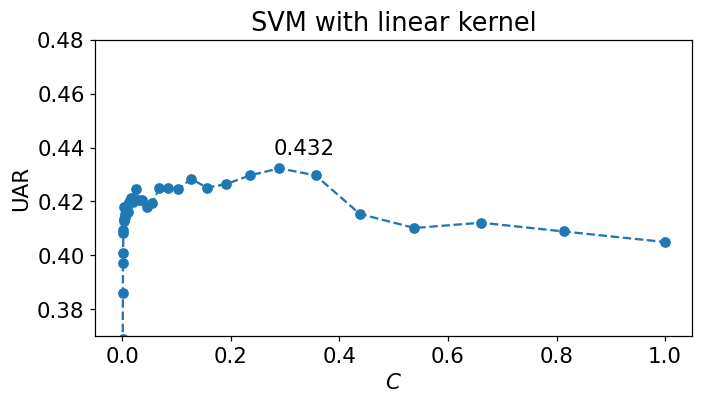

In [17]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

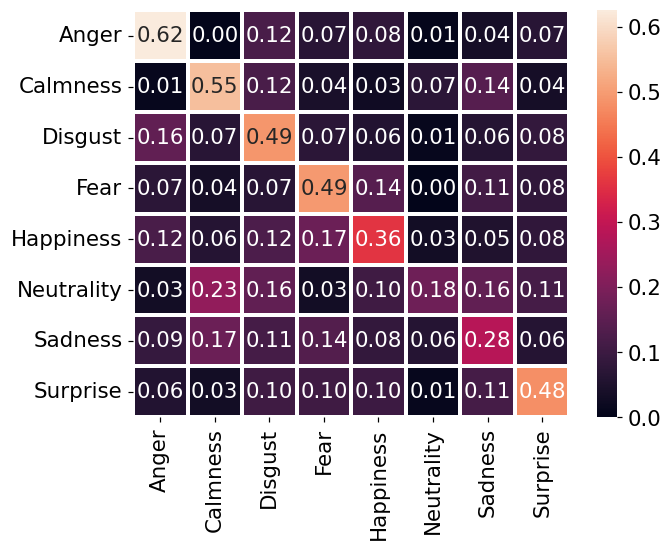

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [18]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)